## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import tensorflow as tf

c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.

In [2]:
tf.__version__


'1.13.1'

In [3]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [4]:
# import tensorflow as tf
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3333)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [5]:
# import tensorflow as tf
# tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 128
MOMENTUM = 0.95
Dropout_EXP = [0.25,0.5]
NUM_NEURONS=[[512, 256, 128], [512, 256, 128, 64]]
OPTIMIZER=['sgd','Adam']

In [11]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}

for N in NUM_NEURONS:
    for D_ratio in Dropout_EXP:
        for OP in OPTIMIZER:
        
            keras.backend.clear_session() # 把舊的 Graph 清掉
            
            model = build_mlp(input_shape=x_train.shape[1:],num_neurons=N, drp_ratio=D_ratio)
            model.summary()

            if(OP=='sgd'):
                optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            else:
                optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)

            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]

    #         exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
            exp_name_tag = str(len(N))+'L'+ " dp=%s" % str(D_ratio)+OP


            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}
            del model

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________________________

Epoch 8/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.7495 - accuracy: 0.3651 - val_loss: 1.6611 - val_accuracy: 0.4200
Epoch 9/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.7333 - accuracy: 0.3688 - val_loss: 1.6635 - val_accuracy: 0.4210
Epoch 10/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.7254 - accuracy: 0.3734 - val_loss: 1.6777 - val_accuracy: 0.4087
Epoch 11/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.7122 - accuracy: 0.3781 - val_loss: 1.6321 - val_accuracy: 0.4231
Epoch 12/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.7092 - accuracy: 0.3817 - val_loss: 1.6176 - val_accuracy: 0.4301
Epoch 13/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.7025 - accuracy: 0.3831 - val_loss: 1.6089 - val_accuracy: 0.4392
Epoch 14/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.6870 - accuracy: 0.3874 - val_lo

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.2074 - accuracy: 0.1585 - val_loss: 2.0262 - val_accuracy: 0.2421
Epoch 2/25
50000/50000 [==============================] - 3s 70us/step - loss: 2.0868 - accuracy: 0.1991 - val_loss: 2.0334 - val_accuracy: 0.2551
Epoch 3/25
50000/50000 [==============================] - 4s 70us/step - loss: 2.0580 - accuracy: 0.2108 - val_loss: 1.9850 - val_accuracy: 0.2461
Epoch 4/25
50000/50000 [==============================] - 3s 70us/step - loss: 2.0391 - accuracy: 0.2188 - val_loss: 2.0202 - val_accuracy: 0.2418
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.0264 - accuracy: 0.2247 - val_loss: 1.9954 - val_accuracy: 0.2782
Epoch 6/25
50000/50000 [==============================] - 4s 70us/step - loss: 2.0196 - accuracy: 0.2314 - val_loss: 1.9834 - val_accuracy: 0.2780
Epoch 7/25
50000/50000 [==============================] - 3s 69us/st

50000/50000 [==============================] - 4s 71us/step - loss: 2.3088 - accuracy: 0.1199 - val_loss: 2.2245 - val_accuracy: 0.1746
Epoch 2/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.2040 - accuracy: 0.1574 - val_loss: 2.1165 - val_accuracy: 0.2043
Epoch 3/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.1436 - accuracy: 0.1739 - val_loss: 2.0612 - val_accuracy: 0.2552
Epoch 4/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.1057 - accuracy: 0.1858 - val_loss: 2.0010 - val_accuracy: 0.2397
Epoch 5/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.0713 - accuracy: 0.2004 - val_loss: 1.9804 - val_accuracy: 0.2463
Epoch 6/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.0416 - accuracy: 0.2142 - val_loss: 1.9535 - val_accuracy: 0.2430
Epoch 7/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.0256 - accuracy: 0.2177 - val_loss: 1.9249 - val

Epoch 20/25
50000/50000 [==============================] - 4s 73us/step - loss: 2.1562 - accuracy: 0.1693 - val_loss: 2.1000 - val_accuracy: 0.2136
Epoch 21/25
50000/50000 [==============================] - 4s 78us/step - loss: 2.1504 - accuracy: 0.1668 - val_loss: 2.1448 - val_accuracy: 0.1872
Epoch 22/25
50000/50000 [==============================] - 4s 83us/step - loss: 2.1507 - accuracy: 0.1689 - val_loss: 2.1511 - val_accuracy: 0.1858
Epoch 23/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.1518 - accuracy: 0.1687 - val_loss: 2.0935 - val_accuracy: 0.2171
Epoch 24/25
50000/50000 [==============================] - 4s 73us/step - loss: 2.1504 - accuracy: 0.1683 - val_loss: 2.1546 - val_accuracy: 0.1939
Epoch 25/25
50000/50000 [==============================] - 4s 73us/step - loss: 2.1505 - accuracy: 0.1700 - val_loss: 2.1227 - val_accuracy: 0.1986


# 請比較使用不同層數以及不同 Dropout rate 對訓練的效果

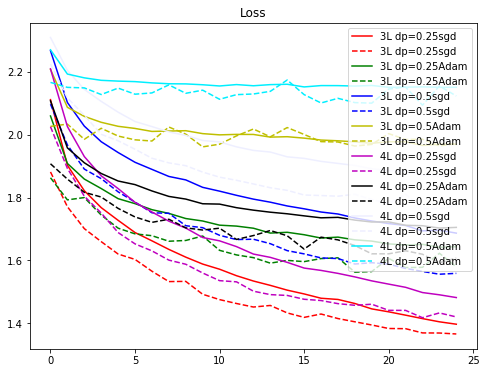

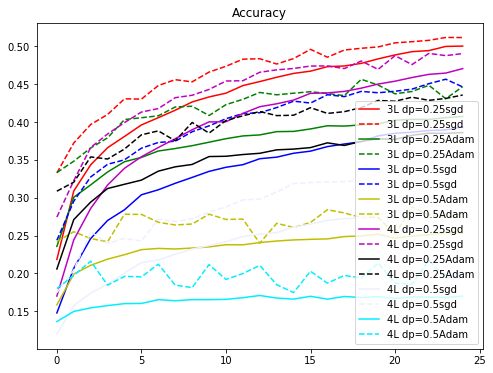

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",'#eeefff','#00efff']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()